# Context
This is what it means to do an internally-consistant fitting test:
1. Take Yirui's true SFH, and fit an approximation with the psb_wild2020 functional form, to get best fit parameters on that fit
2. Use the best fit parameters to generate a spectrum with bagpipes, with sensible other galaxy parameters
3. Use bagpipes to fit for this spectrum (assume SNR = 15, no observational error purtubation), bin by 1, with R_spec = 4340
4. Compare the posterior estimates' predicted spectrum with the spectrum from step 2

After the testing results from the first internally-consistant notebook, just to be sure Bagpipes is able to break outshining when only the simplest models are used, we take off dust here.

In [1]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 10000
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from PyAstronomy import pyasl
import seaborn as sns
import pandas as pd

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


## Step 1: use scipy.optimize.curve_fit to fit a psb2 function to the true SFH

In [2]:
age_at_z = pipes.utils.cosmo.age(0).value
sim_data = np.loadtxt('../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()


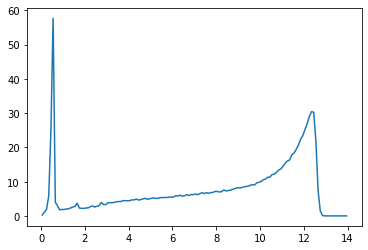

In [3]:
plt.plot(model_ages, model_sfh)

In [4]:
# extracted from bagpipes.models.star_formation_history.py, with a bit of tweaking
def psb_wild2020(age_list, age, tau, burstage, alpha, beta, fburst, Mstar):
    """
    A 2-component SFH for post-starburst galaxies. An exponential
    compoent represents the existing stellar population before the
    starburst, while a double power law makes up the burst.
    The weight of mass formed between the two is controlled by a
    fburst factor: thefraction of mass formed in the burst.
    For more detail, see Wild et al. 2020
    (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494..529W/abstract)
    """
    age_lhs = pipes.utils.make_bins(np.log10(age_list)+9, make_rhs=True)[0]
    age_list = age_list*10**9
    age_lhs = 10**age_lhs
    age_lhs[0] = 0.
    age_lhs[-1] = 10**9*pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    age_widths = age_lhs[1:] - age_lhs[:-1]
    sfr = np.zeros(len(age_list))
    
    age_of_universe = 10**9*np.interp(0, pipes.utils.z_array,
                                               pipes.utils.age_at_z)
    
    age = age*10**9
    tau = tau*10**9
    burstage = burstage*10**9

    ind = (np.where((age_list < age) & (age_list > burstage)))[0]
    texp = age - age_list[ind]
    sfr_exp = np.exp(-texp/tau)
    sfr_exp_tot = np.sum(sfr_exp*age_widths[ind])

    mask = age_list < age_of_universe
    tburst = age_of_universe - age_list[mask]
    tau_plaw = age_of_universe - burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*age_widths[mask])

    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot

    dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr[mask] += fburst * dpl_form / sfr_burst_tot
    
    return sfr*10**Mstar

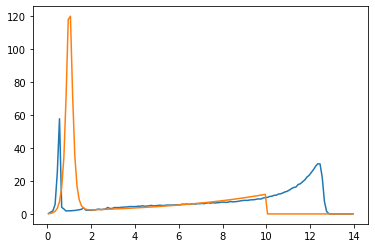

In [5]:
# a test run with random parameters
predict_sfh = psb_wild2020(model_ages, 10, 5, 1, 100, 100, 0.5, 11)
plt.plot(model_ages, model_sfh)
plt.plot(model_ages, predict_sfh)

In [6]:
# using scipy curve fit to get a fit to the true SFH
popt,pcov = scipy.optimize.curve_fit(psb_wild2020, model_ages, model_sfh, 
                                     bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))

In [38]:
# best fits
print(popt)

[1.26818189e+01 4.18757126e+00 5.49999954e-01 1.93479148e+02
 4.59486377e+02 8.99312201e-02 1.10132437e+01]


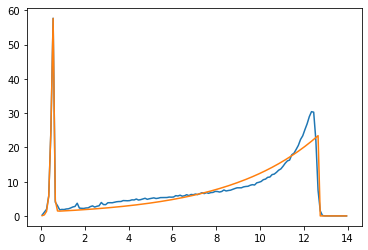

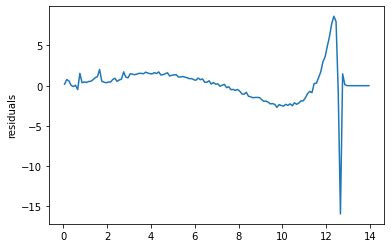

In [8]:
predict_sfh = psb_wild2020(model_ages, *popt)
plt.plot(model_ages, model_sfh)
plt.plot(model_ages, predict_sfh)
plt.show()
plt.plot(model_ages, model_sfh-predict_sfh)
plt.ylabel('residuals')
plt.show()

Turns out that the burst can be very well modelled with a double power law, however the older population does not. It almost looks like a steeper exponential decay model at first, with a linear decline element added afterwards. Ofc course another area of discrapancy is that the increase in SFR is not instataneous as suggested by an exponential decay model. This change from the true SFH to the best fit psb2 SFH should take care of some of the model-data discrapancies.

## Step 2: generate the spectrum from best fit

In [13]:
# load in true spectrum
spectrum = np.loadtxt(fname="../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test.csv", delimiter=',', skiprows=1)
spectrum[:,1] = spectrum[:,1]*10**-16
wavelengths = spectrum[:,0]

In [14]:
# non-sfh parameters based on posterior mean of run yirui_test_snap119_veldisp_off_SNR15_bin_by_1 
# (read off of corner plot)
psb = {}
psb['massformed'] = popt[-1]
psb['metallicity'] = 1.0 # solar metallicity
psb['age'] = popt[0]
psb['tau'] = popt[1]
psb['burstage'] = popt[2]
psb['alpha'] = popt[3]
psb['beta'] = popt[4]
psb['fburst'] = popt[5]

model_components = {}
model_components['psb_wild2020'] = psb
model_components['redshift'] = 0.04

best_fit_model = pipes.model_galaxy(model_components, spec_wavs=wavelengths)

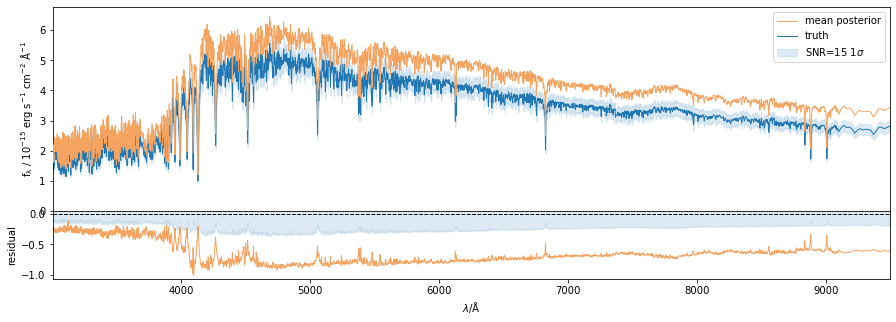

In [15]:
def plot_spec(wavelengths, true_spec, model_spec, limit_to_9500=False):
    if limit_to_9500:
        to_ind = [wavelengths<9500]
        wavelengths = wavelengths[to_ind]
        true_spec = true_spec[to_ind]
        model_spec = model_spec[to_ind]
    fig = plt.figure(figsize=[15,5])
    gs = fig.add_gridspec(4,1, hspace=0, wspace=0)
    ax1 = plt.subplot(gs[:-1])
    ax2 = plt.subplot(gs[-1])

    y_scale = pipes.plotting.add_spectrum(model_spec, ax1, label='mean posterior', lw=1)
    ax1.plot(wavelengths, true_spec[:,1]*10**-y_scale, label='truth', lw=1)
    ax1.fill_between(wavelengths, true_spec[:,1]*10**-y_scale-true_spec[:,1]*10**-y_scale/15, 
                     true_spec[:,1]*10**-y_scale+true_spec[:,1]*10**-y_scale/15,
                    color='C0', alpha=0.15, zorder=-1, label=r'SNR=15 1$\sigma$')
    ax1.legend()

    ax2.axhline(0, color="black", ls="--", lw=1)
    ax2.plot(wavelengths, (true_spec[:,1] - model_spec[:,1])*10**-y_scale, color='sandybrown', lw=1)
    ylims = ax2.get_ylim()
    ax2.fill_between(wavelengths, -true_spec[:,1]*10**-y_scale/15, true_spec[:,1]*10**-y_scale/15,
                    color='C0', alpha=0.15, zorder=-1, label=r'SNR=15 1$\sigma$')
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ylims)
    ax2.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax2.set_ylabel('residual')

    plt.show()
    
plot_spec(wavelengths, spectrum, best_fit_model.spectrum, limit_to_9500=True)

This generated spectrum will not be perfect, since the dust law, its parameters and many other things are likely very far from what Yirui used to create the datacube at the first place. But as long as we only check against this generated spectrum later on, we can still be self-consistant.

In [16]:
SNR = 15
spectrum_1sigma = best_fit_model.spectrum[:,1]*10**16/SNR
new_spectrum = pd.DataFrame({'observed-wave[AA]': best_fit_model.spectrum[:,0],
                             'flux[10^-16 erg/s/cm^2/AA]': best_fit_model.spectrum[:,1]*10**16,
                             'noise[10^-16 erg/s/cm^2/AA]': spectrum_1sigma})
new_spectrum.to_csv('best_fit_datacube_summed_no_dust_SNR15_no_perturbation.csv', index=False)

the file `best_fit_datacube_summed_with_dust_SNR15_no_perturbation2.csv` is avaliable here:
https://universityofstandrews907-my.sharepoint.com/:x:/g/personal/hhl1_st-andrews_ac_uk/EUaT0KhDy0hKpaR14_wZ8ncBvCmwfBH9aAWDYTV3ggmaQw?e=dgkopA

## Step 3: fit the spectrum and analyze the results
R_spec = 4340 <br>
Note: Fits have psb2:beta as a free parameter <br>
Fitting posterior files and plots here:
https://universityofstandrews907-my.sharepoint.com/:f:/g/personal/hhl1_st-andrews_ac_uk/EmAMsNCgl-hCkOcelDVg8akBmBDSxqcKMUcvnZUsQ4rw1A?e=LnmJ7m

In [17]:
def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    ind = np.where(wave<3000)
    mask.extend(ind[0])    

    return mask

def load_uds_spectrum_mask(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname=ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum
    

def load_uds_mask(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask(ID,z)

    return spectrum

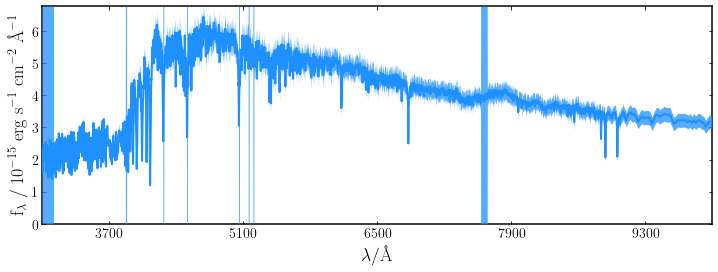

In [18]:
ID = 'best_fit_datacube_summed_no_dust_SNR15_no_perturbation'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fig = galaxy.plot()

In [46]:
def plot_spec2(fit, ID, runID):
    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    fit.posterior.get_advanced_quantities()

    naxes=1
    fig = plt.figure(figsize=(12, 5.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1)
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)

    post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(fit.galaxy.spectrum[:,0],(post_median - fit.galaxy.spectrum[:,1])*10**-y_scale, color="sandybrown")
    #ax1.set_xlim([3000,4200])
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax3.set_ylabel('residual')
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
    plt.show()
    
def integrate_sfh(ages, sfh, Mstar=None):
    """ 
    takes a sfh and integrates it to return a cumulative SFH (normalized to run from 0 to 1) fraction of 
    mass formed
    """
    if Mstar is None:
        Mstar = np.trapz(y=sfh,x=ages)
    c_sfh = np.zeros(len(sfh))
    for i,sfhi in enumerate(sfh):
        c_sfh[i] = np.trapz(sfh[:i+1],x=ages[:i+1]/Mstar)
    return c_sfh
    
def plot_sfh(fit, model_lookbacktime, model_sfh, ID, runID):
    """
    Plots the regular SFH (SFR vs age of universe) plot on the top, cumulative SFH plot on the bottom
    """
    if 'redshift' in fit.posterior.samples.keys():
        post_z = np.median(fit.posterior.samples['redshift'])
    else: post_z = 0.04
    age_at_z = pipes.utils.cosmo.age(post_z).value

    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    median_sfh = np.median(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_ages_int = post_ages.copy()[::-1]*10**9
    post_m_total = np.trapz(y=median_sfh[::-1], x=post_ages_int)
    # integrate to get cumulative median
    c_median_sfh = integrate_sfh(post_ages_int, median_sfh[::-1], Mstar=post_m_total)

    #model sfh
    model_sfh = model_sfh.copy()
    model_ages = age_at_z-model_lookbacktime.copy()
    model_ages_int = model_ages.copy()[::-1]*10**9
    model_m_total = np.trapz(y=model_sfh[::-1], x=model_ages_int)
    # integrate to get cumulative of model sfh
    c_model_sfh = integrate_sfh(model_ages_int, model_sfh[::-1], Mstar=model_m_total)
    
    print('only recovered',post_m_total/model_m_total,'of total mass formed.')
    print(np.log10(post_m_total), np.log10(model_m_total))

    #calculating posterior tx and their uncertainties
    mass_percentiles = np.linspace(0,1,5)[1:-1]
    txs = []
    c_sfh_samples = []
    for sfh_sample in fit.posterior.samples['sfh']:
        sfh_ = sfh_sample[::-1]
        c_sfh_ = integrate_sfh(post_ages_int, sfh_)
        c_sfh_samples.append(c_sfh_)
        txs.append(np.interp(mass_percentiles, c_sfh_, post_ages_int))
    txs = (np.array(txs)/10**9).T
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    #print(tx_percentiles)
    c_sfh_percentiles = np.percentile(c_sfh_samples, (16,50,84), axis=0)
    
    ################# plotting 
    
    fig, ax = plt.subplots(2,1, figsize=[15,10])
    pipes.plotting.add_sfh_posterior(fit, ax[0], z_axis=False)
    ax[0].plot(model_ages, model_sfh)
    ylim = ax[0].get_ylim()

    #calculate model burst fraction
    model_f_burst = popt[5]
    model_t_burst = age_at_z - popt[2]
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    ax[0].vlines(model_t_burst, 0, ylim[1], color='red', ls='--')
    ax[0].arrow(age_at_z,ylim[1]*0.8,-(age_at_z-model_t_burst),0.0,color='red',head_width=np.max(ylim)/20., 
             head_length=0.1,length_includes_head=True)

    #use psb2's built in fburst and tburst posteriors to plot arrows
    post_f_burst = np.percentile(fit.posterior.samples['psb2:fburst'], (16,50,84))
    post_t_burst = age_of_universe-np.percentile(fit.posterior.samples['psb2:burstage'], (84,50,16))

    print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
    ax[0].vlines(post_t_burst[1], 0, ylim[1], color='sandybrown', ls='--')
    ax[0].arrow(age_of_universe,ylim[1]*0.9,-(age_of_universe-post_t_burst[1]),0.0,color='sandybrown',
             head_width=np.max(ylim)/20., head_length=0.1,length_includes_head=True)

    #plot vertical bands of tx percentiles
    for i,[l,m,u] in enumerate(tx_percentiles):
        ax[0].vlines(m, 0, 10*ylim[1], color = 'k', ls='--', alpha=0.5)
        ax[0].fill_betweenx([0,10*ylim[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
    
    ax[0].set_ylim(ylim)
    #add text about z, age at z, poster f_burst and t_burst
    f_burst_r = [np.round(post_f_burst[1],2),np.round(post_f_burst[2]-post_f_burst[1],2),
                 np.round(post_f_burst[1]-post_f_burst[0],2)]
    f_burst_text = f'post f\_burst={f_burst_r[0]}+{f_burst_r[1]}-{f_burst_r[2]}\n '
    t_burst_r = [np.round(post_t_burst[1],2),np.round(post_t_burst[2]-post_t_burst[1],2),
                 np.round(post_t_burst[1]-post_t_burst[0],2)]
    t_burst_text = f'post t\_burst={t_burst_r[0]}+{t_burst_r[1]}-{t_burst_r[2]}Gyr \n '
    ax[0].text(0.03,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr\n ' + 
            f_burst_text + 
            f'true f\_burst={np.round(model_f_burst,2)}\n ' +
            t_burst_text +
            f'true t\_burst={np.round(model_t_burst,2)}Gyr',
            fontsize=14, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    pipes.plotting.add_z_axis(ax[0])
    
    ax[1].plot(model_ages[::-1], c_model_sfh, zorder=1)
    ax[1].plot(post_ages[::-1], c_sfh_percentiles[1], color='k', zorder=1)
    ax[1].fill_between(post_ages[::-1], c_sfh_percentiles[0], c_sfh_percentiles[2], color='gray', 
                       alpha=0.6, zorder=0)
    ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,5)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                        tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='red', label='calculated equivilent tx times (assuming 4 bins)', fmt='o', zorder=2)
    
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel(ax[0].get_xlabel())
    ax[1].set_ylabel('fraction of cumulative mass formed')
    
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
    return fig,ax
    
def make_plots(galaxy, ID, runID, model_ages, predict_sfh):
    fit = pipes.fit(galaxy, {}, run=runID)
    plot_spec2(fit, ID, runID)
    fig = fit.plot_sfh_posterior(save=True, show=True)
    fig = fit.plot_corner(save=True, show=True)
    plot_sfh(fit, model_ages, predict_sfh, ID, runID)


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec4340_no_dust/best_fit_datacube_summed_no_dust_SNR15_no_perturbation.h5



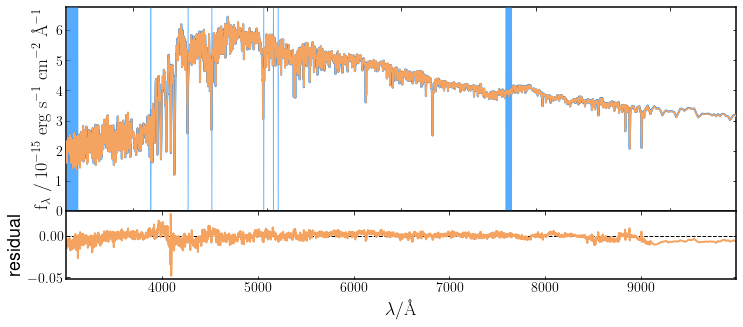

only recovered 0.8015744728244569 of total mass formed.
10.916938556529642 11.012994678455577
model f_burst and t_burst: 0.08993122012854099 12.37406020407221
posterior f_burst and t_burst: [0.08661081 0.09518196 0.10752   ] [12.4153029  12.48445511 12.53639161]


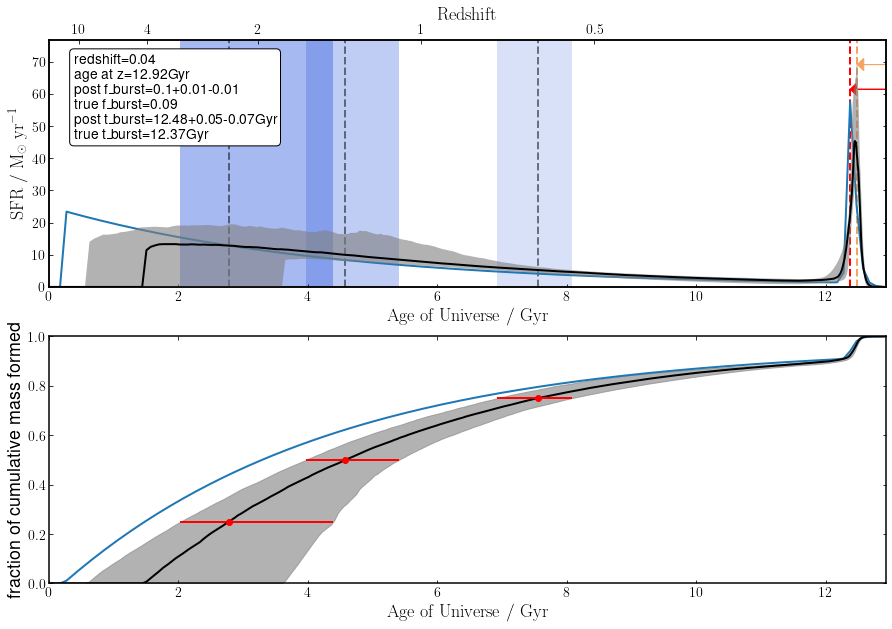

In [47]:
make_plots(galaxy, ID, "outshining_internally_consistant_test_Rspec4340_no_dust", model_ages, predict_sfh)

In [24]:
10**10.98/10**11.013

0.9268298233793504

In [50]:
np.percentile(fit.posterior.samples['formed_mass'],(16,50,84))

array([10.95651024, 10.97481353, 10.99160663])

### Comments:
1. Posterior SFH reaches ages <2 Gyr, indicating not severe outshining.
2. Total mass estimated is log10Mstar = $10.98\pm0.02$, a bit way from the true value 11.013. There is a ~8% mass loss. Not significant, as it did not inflate the fburst value drastically.
3. tburst seems to be off. There is a strong anti-correlation between tburst and beta, perhaps that has something to do with it.

## Step 4: compare spectra predicted from these posteriors against the spectrum in step 2

In [27]:
def make_model_components(age, tau, massformed, metallicity, burstage, alpha, beta, fburst, redshift):

    psb2 = {}
    psb2["age"] = age                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb2["tau"] = tau                   # Vary tau between 300 Myr and 10 Gyr
    psb2["massformed"] = massformed              # vary log_10(M*/M_solar) between 1 and 15
    psb2["metallicity"] = metallicity           # vary Z between 0.1 and 2.5 Z_solar

    psb2["burstage"] = burstage                   # age of burst from 0 to 2Gyr
    psb2["alpha"] = alpha              # decline of burst
    psb2["beta"] = beta                    # rise of burst: fixed
    psb2["fburst"] = fburst

    model_components = {}
    model_components['psb_wild2020'] = psb2
    model_components['redshift'] = redshift
    return model_components

def limit_and_plot(median_spectrum, samp_spectra, true_spec, wavelengths, limits=None):
    if limits is not None:
        to_ind = (limits[0]<wavelengths)*(wavelengths<limits[1])
    else:
        to_ind = [wavelengths<9500]
    wavelengths = wavelengths[to_ind]
    median_spectrum = median_spectrum[to_ind]
    true_spec = true_spec[to_ind]
    for i in range(len(samp_spectra)):
        samp_spectra[i] = samp_spectra[i][to_ind]
        
    # the residual comparison plot
    fig = plt.figure(figsize=[15,15])
    gs = fig.add_gridspec(2,1, hspace=0)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    y_scale = pipes.plotting.add_spectrum(median_spectrum, ax1, 
                                          label='median posterior', lw=1, color='sandybrown')
    ax1.plot(wavelengths, true_spec[:,1]*10**-y_scale, label='truth', lw=1)
    for samp_spec in samp_spectra:
        pipes.plotting.add_spectrum(samp_spec, ax1, lw=1, color='k', alpha=0.1)
    ax1.legend()
    if limits is not None:
        ax1.set_xlim(limits)

    ax2.axhline(0, color="black", ls="--", lw=1)
    ax2.plot(wavelengths, (true_spec[:,1] - median_spectrum[:,1])*10**-y_scale, 
             label='median posterior', lw=1, color='sandybrown')
    for samp_spec in samp_spectra:
        ax2.plot(wavelengths, (true_spec[:,1] - samp_spec[:,1])*10**-y_scale, 
                 lw=1, color='k', alpha=0.1)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax2.set_ylabel('residual')

    plt.show()

def compare_posterior_with_truth(runID):
    keys = ['psb2:age', 'psb2:tau', 'psb2:massformed', 'psb2:metallicity', 
            'psb2:burstage', 'psb2:alpha', 'psb2:beta', 'psb2:fburst', 'redshift']
    fit = pipes.fit(galaxy, {}, run=runID)
    # take out 10 samples and median posteriors from the fits
    medians = []
    for key in keys:
        medians.append(np.median(fit.posterior.samples[key]))
    median_model = pipes.model_galaxy(make_model_components(*medians), spec_wavs=wavelengths)
    median_spectrum = median_model.spectrum

    samp_len = len(fit.posterior.samples['psb2:age'])
    samp_ind = np.random.randint(samp_len, size=10)
    samps = []
    samp_spectra = []
    for i,ind in enumerate(samp_ind):
        sample_vals = []
        for key in keys:
            sample_vals.append(fit.posterior.samples[key][ind])
        samps.append(sample_vals)
        samp_model = pipes.model_galaxy(make_model_components(*sample_vals), spec_wavs=wavelengths)
        samp_spectra.append(samp_model.spectrum)
    
    limit_and_plot(median_spectrum.copy(), samp_spectra.copy(), best_fit_model.spectrum.copy(), wavelengths.copy())
    limit_and_plot(median_spectrum.copy(), samp_spectra.copy(), best_fit_model.spectrum.copy(), wavelengths.copy(),
                   limits=[3700,4200])
    limit_and_plot(median_spectrum.copy(), samp_spectra.copy(), best_fit_model.spectrum.copy(), wavelengths.copy(),
                   limits=[6600,7100])


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec4340_no_dust/best_fit_datacube_summed_no_dust_SNR15_no_perturbation.h5



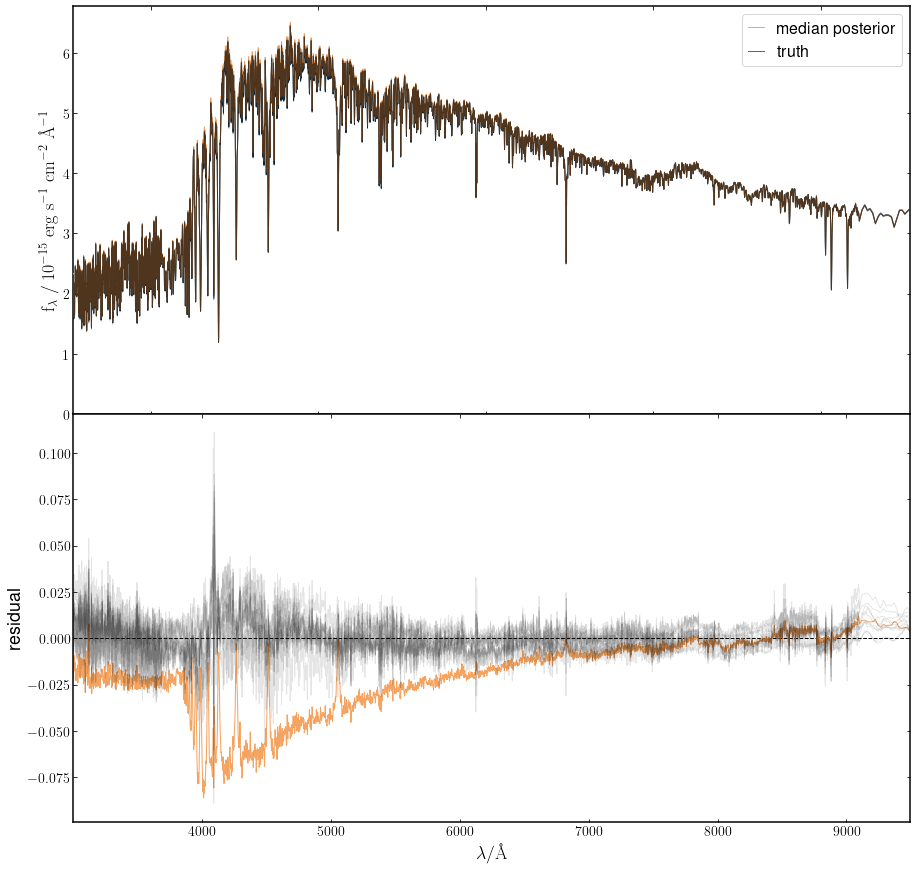

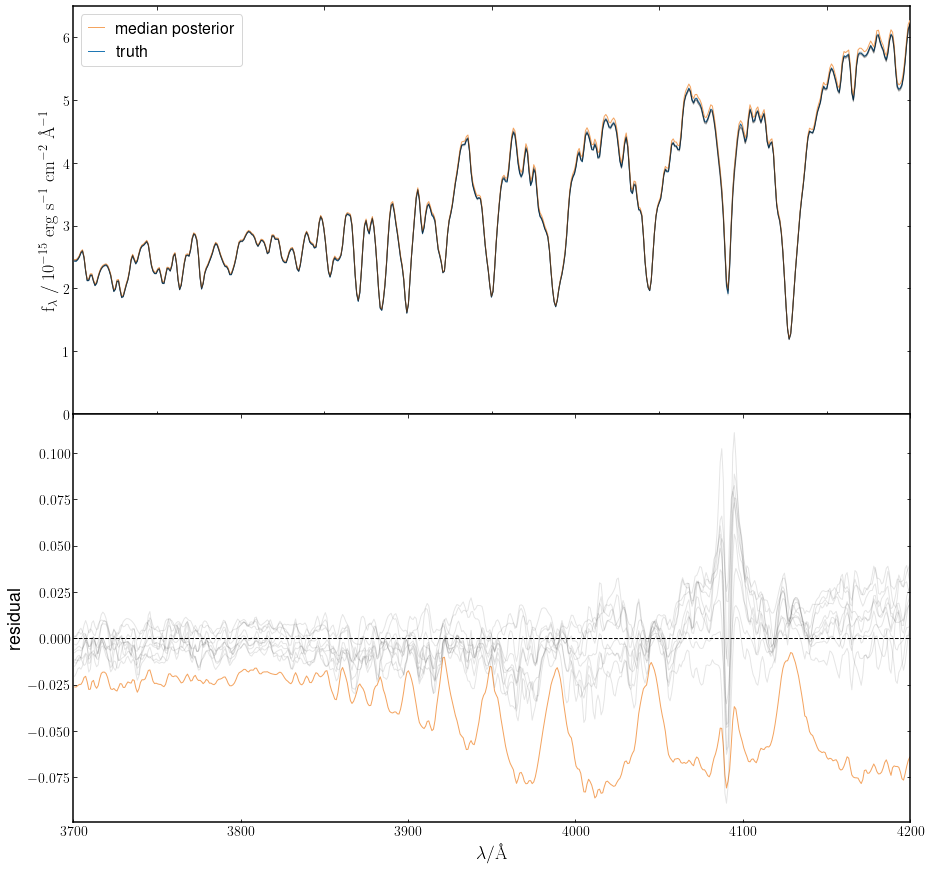

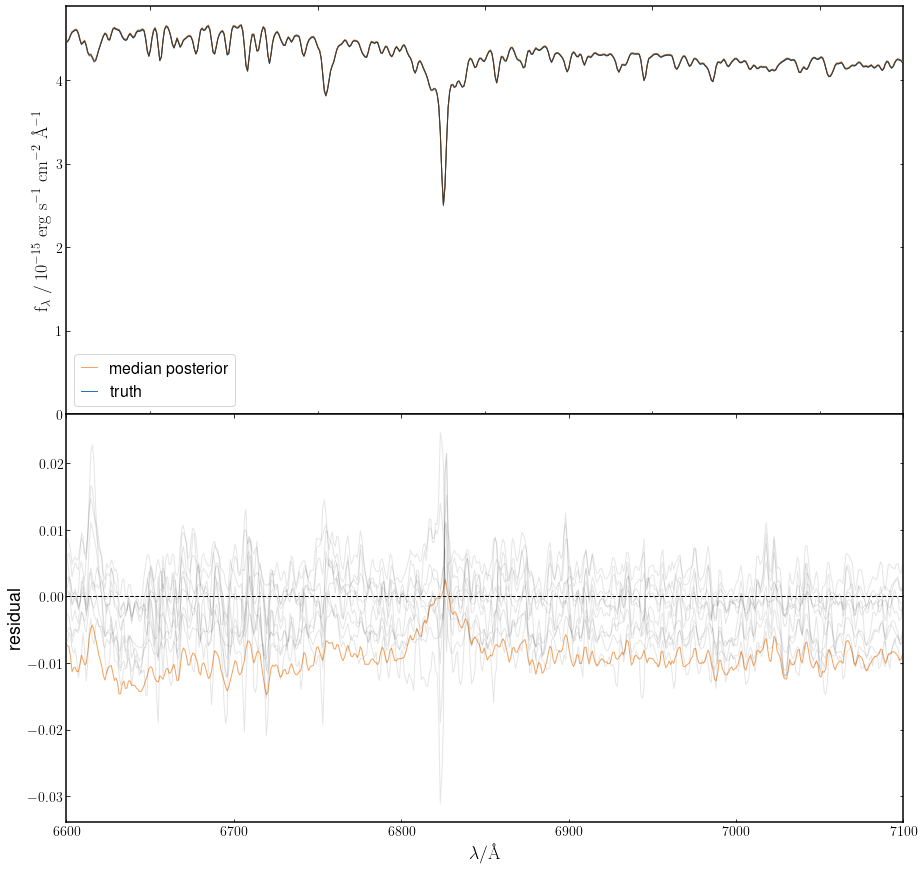

In [28]:
compare_posterior_with_truth("outshining_internally_consistant_test_Rspec4340_no_dust")

## Bonus: compare posterior estimations against best fit with dist plots


Results loaded from pipes/posterior/outshining_internally_consistant_test_Rspec4340_no_dust/best_fit_datacube_summed_no_dust_SNR15_no_perturbation.h5



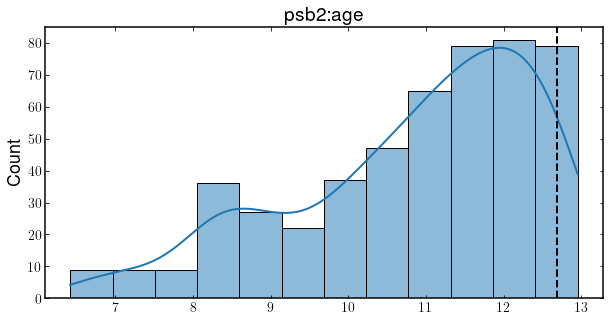

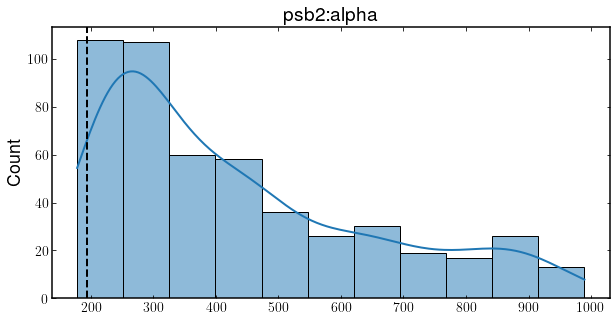

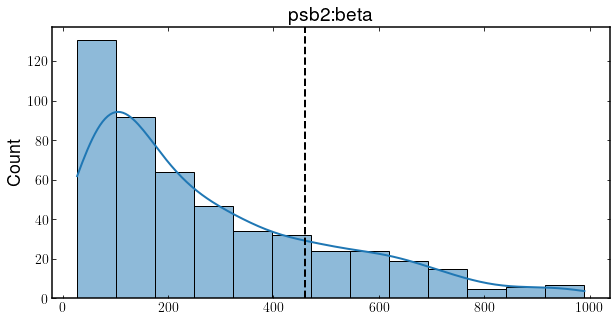

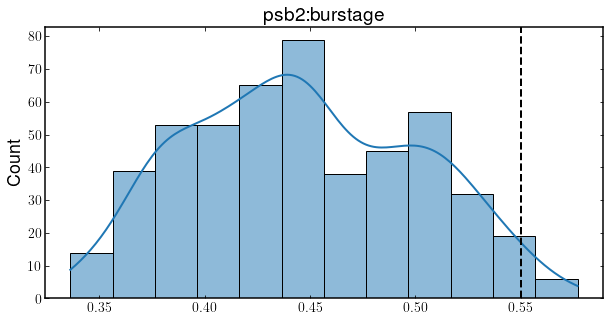

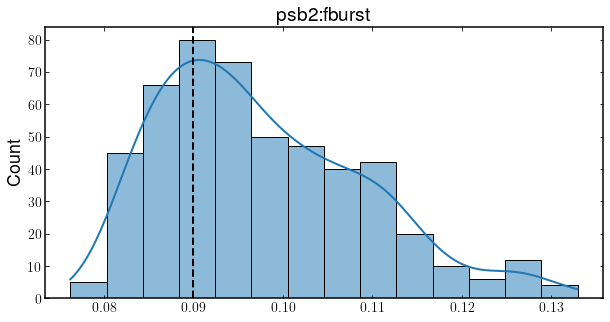

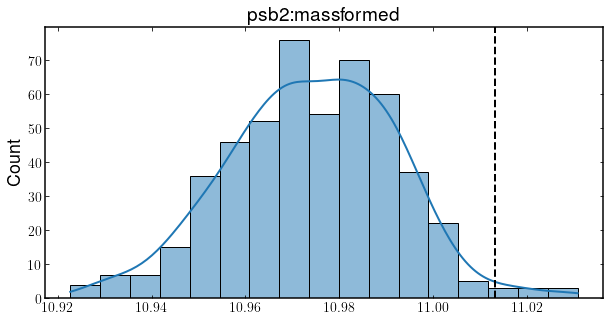

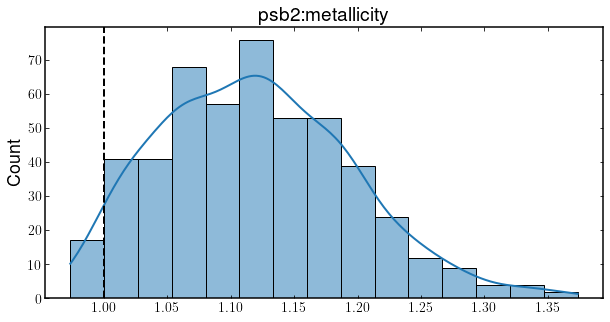

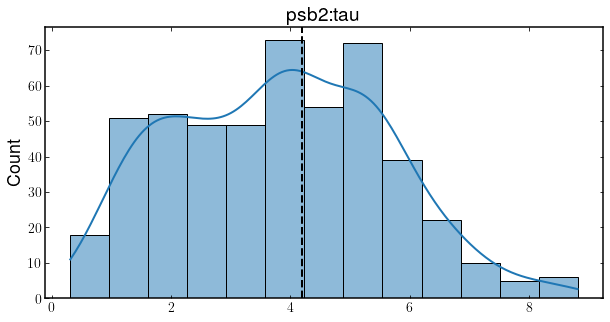

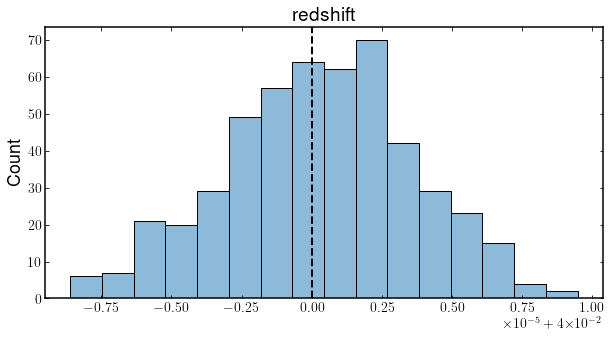

In [39]:
fit = pipes.fit(galaxy, {}, run="outshining_internally_consistant_test_Rspec4340_no_dust")

for key in ['psb2:age', 'psb2:alpha', 'psb2:beta', 'psb2:burstage', 'psb2:fburst', 
            'psb2:massformed', 'psb2:metallicity', 'psb2:tau', 'redshift']:
    fig, ax = plt.subplots(figsize=[10,5])
    sns.histplot(fit.posterior.samples[key], kde=True, ax=ax)
    if ':' in key:
        truth = psb[key.split(':')[1]]
    else:
        truth = model_components[key]
    ax.axvline(truth, color='k', ls='--')
    ax.set_title(key)
    plt.show()

Comments:
1. Without dust, SFH properties are better recovered. However, Mstar posterior median sits >2 sigma away from truth, indicating still some outshining.
2. Metallicity's posterior is biased.